<a href="https://colab.research.google.com/github/mylethidiem/artificial-intelligence-projects/blob/main/IoT%20Project%20Light%20Controlling%20Using%20Hand%20Gestures/hand_gesture_recgonition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir data

In [2]:
# If not run step Prepare data
!gdown  1gzWOtABiVmJ38usCSDe5F9gR2tECt3zu -O data/
!gdown  15lwipssmC_K82ukRfb0uVCiDH1TZ3QCf -O data/
!gdown  1nIo1_wBmkovz-u_BCsV5c1Kbz6ZqoKwq -O data/
# Download file hand_gesture.yam
!gdown  1ZteHYSgbuZu_GcUJHW8ZzoZv1DE8-oLw

Downloading...
From: https://drive.google.com/uc?id=1gzWOtABiVmJ38usCSDe5F9gR2tECt3zu
To: /content/data/landmark_val.csv
100% 369k/369k [00:00<00:00, 42.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=15lwipssmC_K82ukRfb0uVCiDH1TZ3QCf
To: /content/data/landmark_train.csv
100% 1.28M/1.28M [00:00<00:00, 100MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nIo1_wBmkovz-u_BCsV5c1Kbz6ZqoKwq
To: /content/data/landmark_test.csv
100% 320k/320k [00:00<00:00, 91.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZteHYSgbuZu_GcUJHW8ZzoZv1DE8-oLw
To: /content/hand_gesture.yaml
100% 120/120 [00:00<00:00, 533kB/s]


[MediaPipe](https://ai.google.dev/edge/mediapipe/solutions/vision/hand_landmarker) is an open framework from Google

In [3]:
!pip install mediapipe==0.10.18

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 47.9 MB/s eta 0:00:00


[TorchMetrics](https://lightning.ai/docs/torchmetrics/stable/) is a collection of 100+ PyTorch metrics implementations and an easy-to-use API to create custom metrics

In [4]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [5]:
import os
import yaml
import cv2 # OpenCV
import numpy as np
import pandas as pd
from datetime import datetime

import torch
import torch.optim as optim
from torch import nn

import mediapipe as mp

from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader


In [6]:
def label_dict_from_config_file(file_path):
  label_tag = []
  with open(file_path, 'r') as f:
    label_tag = yaml.full_load(f)['gestures']
  return label_tag

In [17]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    input = 63
    hidden = 128
    rate = [0.4, 0.6]
    list_label = label_dict_from_config_file("hand_gesture.yaml")
    output = len(list_label)

    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(input, hidden),
        nn.ReLU(),
        nn.BatchNorm1d(hidden),

        nn.Linear(hidden, hidden),
        nn.ReLU(),
        nn.Dropout(p=rate[0]),

        nn.Linear(hidden, hidden),
        nn.ReLU(),
        nn.Dropout(p=rate[0]),

        nn.Linear(hidden, hidden),
        nn.ReLU(),
        nn.Dropout(p=rate[1]),

        nn.Linear(hidden, output)
    )
    # q1 A
    # for m in self.modules():
    #   if isinstance(m, nn.Linear):
    #     nn.init.normal_(m.weight, mean=0.0, std=0.05)
    #     nn.init.constant_(m.bias, val=0.0)

  def forward(self, x):
    x  = self.flatten(x)
    #q2 A
    output = self.linear_relu_stack(x)
    return output

  def predict(self, x, threshold=0.8):
    logits = self(x)
    softmax_prob = nn.Softmax(dim=1)(logits)
    chosen_ind = torch.argmax(softmax_prob, dim=1)
    return torch.where(softmax_prob[0, chosen_ind] > threshold, chosen_ind, -1)

  def predict_with_known_class(self, x):
    logits = self(x)
    softmax_prob = nn.Softmax(dim=1)(logits)
    return torch.argmax(softmax_prob, dim=1)

  def score(self, logits):
    return -torch.amax(logits, dim=1)


In [19]:
class HanddLandmarkDetector():
  def __init__(self) -> None:
    # drawing onto image
    self.mp_drawing_utils = mp.solutions.mp_drawing_utils
    self.mp_drawing_styles = mp.solutions.mp_drawing_styles

    # detector hand gestures
    self.mp_hands = mp.solutions.hands
    self.detector = self.mp_hands.Hands(static_image_mode=False,
                                        max_num_hands=1,
                                        min_detection_confidence=0.5)

  def detect_hand(self, frame):
    hands = []

    # flip the frame horizontally (mirror effect)
    frame = cv2.flip(frame, flipCode=1)

    annotated_image = frame.copy()

    results = self.detector.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    if results.multi_hand_landmarks is not None:
      for hand_landmarks in results.multi_hand_landmarks:
        hand = []

        # draw hand landmarks into image
        self.mp_drawing_utils(
            image=annotated_image,
            landmark_list=hand_landmarks,
            connection=self.mp_hands.HAND_CONNECTIONS,
            landmark_drawing_spec=self.mp_drawing_styles.get_default_hand_landmarks_style(),
            connection_drawing_spec=self.mp_drawing_styles.get_default_hand_connections_style()
        )

        for landmark in hand_landmarks.landmark:
          x, y, z = landmark.x, landmark.y, landmark.z
          hand.extend(x, y, z)
        hands.append(hand)
    return hands, annotated_image


In [20]:
class CustomImageDataset(Dataset):
    # Custom dataset class for loading images and their labels

    def __init__(self, data_file):
        # Initialize the dataset
        self.data = pd.read_csv(data_file)  # Read the data file (CSV) containing image data and labels into a pandas DataFrame
        self.labels = torch.from_numpy(self.data.iloc[:, 0].to_numpy())  # Convert the first column (labels) to a NumPy array and then to a PyTorch tensor

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)  # Return the length of the data DataFrame

    def __getitem__(self, idx):
        # Get a sample from the dataset
        one_hot_label = self.labels[idx]  # Get the label for the given index
        torch_data = torch.from_numpy(self.data.iloc[idx, 1:].to_numpy(dtype=np.float32))  # Convert the image data (all columns except the first) to a NumPy array and then to a PyTorch tensor
        return torch_data, one_hot_label  # Return the image data and label as a tuple

In [21]:
class EarlyStopper:
    # Class for early stopping during training

    def __init__(self, patience=1, min_delta=0.0):
        # Initialize the early stopper
        self.patience = patience  # Number of epochs to wait before stopping
        self.min_delta = min_delta  # Minimum change in the monitored quantity to qualify as an improvement
        self.counter = 0  # Counter for the number of epochs without improvement
        self.watched_metrics = np.inf  # Initialize the watched metric to infinity

    def early_stop(self, current_value):
        # Check if training should be stopped
        if current_value < self.watched_metrics:
            # If the current value is better (lower) than the watched metric
            self.watched_metrics = current_value  # Update the watched metric
            self.counter = 0  # Reset the counter
        elif current_value > (self.watched_metrics + self.min_delta):
            # If the current value is worse (higher) than the watched metric plus the minimum delta
            self.counter += 1  # Increment the counter
            if self.counter >= self.patience:
                # If the counter exceeds the patience threshold
                return True  # Stop training
        return False  # Continue training

In [29]:
def train(train_loader, val_loader, model, loss_function, optimizer, early_stopper):
  # add auroc score
  epochs = 300
  best_vloss = 1_000_000
  timestamp = datetime.now().strftime('%d-%m %H:%M')
  best_model_path = ''
  train_loss_list = []
  train_acc_list = []
  val_loss_list = []
  val_acc_list = []

  for epoch in range(300):
    #training step
    model.train(True)
    running_loss = 0.0
    acc_train = Accuracy(num_classes=len(LIST_LABEL), task='MULTICLASS')
    for batch_number, data in enumerate(train_loader):
      inputs, labels = data

      #q9 A
      optimizer.zero_grad()
      preds = model(inputs)

      #q10 A
      loss = loss_function(preds, labels)

      loss.backward()
      optimizer.step()

      acc_train.update(model.predict_with_known_class(inputs), labels) #
      running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    #validating step
    model.train(False)
    running_vloss = 0.0
    acc_val = Accuracy(num_classes=len(LIST_LABEL), task='MULTICLASS')
    for i, vdata in enumerate(val_loader):
      vinputs, vlabels = vdata
      preds = model(vinputs)
      vloss = loss_function(preds, vlabels)
      running_vloss += vloss.item()
      acc_val.update(model.predict_with_known_class(vinputs), vlabels)

    # Log the running loss averaged per batch
    # for both training and validation
    print(f"Epoch {epoch}/{epochs}:")
    print(f"Accuracy train: {acc_train.compute().item()}, val:{acc_val.compute().item()}")

    avg_vloss = running_vloss / len(val_loader)
    train_loss_list.append(avg_loss)
    train_acc_list.append(acc_train.compute().item())
    val_loss_list.append(avg_vloss)
    val_acc_list.append(acc_val.compute().item())

    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print('Training vs. Validation Loss',
          {'Training' : avg_loss, 'Validation': avg_vloss},
          epoch + 1)
    print('Training vs. Validation accuracy',
          {'Training' : acc_train.compute().item(),
           'Validation' : acc_val.compute().item()},
          epoch + 1)

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
      best_vloss = avg_vloss
      best_model_path = f'./{save_path}/model_{timestamp}_{model.__class__.__name__}_best'
      torch.save(model.state_dict(), best_model_path) # Save the model's state

    #q5 A
    if early_stopper.early_stop(avg_vloss):
      print(f"Stopping at {epoch}, minium: {early_stopper.watched_metrics}")
      break

  model_path = f'./{save_path}/model_{timestamp}_{model.__class__.__name__}_last'
  torch.save(model.state_dict(), model_path)
  train_val_loss_acc = [train_loss_list, train_acc_list, val_loss_list, val_acc_list]


  return model, best_model_path, train_val_loss_acc


In [23]:
DATA_FOLDER_PATH="./data/"
LIST_LABEL = label_dict_from_config_file("hand_gesture.yaml")
train_path = os.path.join(DATA_FOLDER_PATH, "landmark_train.csv")
val_path = os.path.join(DATA_FOLDER_PATH, "landmark_val.csv")
test_path = os.path.join(DATA_FOLDER_PATH, "landmark_test.csv")

trainset = CustomImageDataset(train_path)
testset = CustomImageDataset(test_path)
valset = CustomImageDataset(os.path.join(val_path))

save_path = './models'
os.makedirs(save_path, exist_ok=True)

#q3 A
batch_size_train = 40
batch_size_val = 40
#q6 A
batch_size_test = 20

test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size_test, shuffle=False)
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size_train, shuffle=True)
val_loader =  torch.utils.data.DataLoader(dataset=valset, batch_size=batch_size_val, shuffle=False)

In [31]:
#q8 A
model = NeuralNetwork()
loss_function = nn.CrossEntropyLoss()
min_delta = 1e-2
early_stopper = EarlyStopper(patience=30, min_delta=min_delta)

#q4 A
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [32]:
model, best_model_path, train_val_loss_acc = train(train_loader, val_loader, model, loss_function, optimizer, early_stopper)

Epoch 0/300:
Accuracy train: 0.23454366624355316, val:0.2935153543949127
LOSS train 1.6052481348697956 valid 1.6046594232320786
Training vs. Validation Loss {'Training': 1.6052481348697956, 'Validation': 1.6046594232320786} 1
Training vs. Validation accuracy {'Training': 0.23454366624355316, 'Validation': 0.2935153543949127} 1
Epoch 1/300:
Accuracy train: 0.3091265857219696, val:0.3788395822048187
LOSS train 1.5844900332964384 valid 1.5815521627664566
Training vs. Validation Loss {'Training': 1.5844900332964384, 'Validation': 1.5815521627664566} 2
Training vs. Validation accuracy {'Training': 0.3091265857219696, 'Validation': 0.3788395822048187} 2
Epoch 2/300:
Accuracy train: 0.3729146122932434, val:0.36518770456314087
LOSS train 1.5641418282802289 valid 1.5657379180192947
Training vs. Validation Loss {'Training': 1.5641418282802289, 'Validation': 1.5657379180192947} 3
Training vs. Validation accuracy {'Training': 0.3729146122932434, 'Validation': 0.36518770456314087} 3
Epoch 3/300:
Ac

In [40]:
import matplotlib.pyplot as plt
def visualization(train_loss_list, train_acc_list, val_loss_list, val_acc_list):
  fig, ax = plt.subplots(2, 2, figsize=(12, 10))

  ax[0,0].plot(train_loss_list, color='green')
  ax[0,0].set(title='Train Loss', xlabel='Epoch', ylabel='Loss')

  ax[0,1].plot(train_acc_list, color='green')
  ax[0,1].set(title='Train Accuracy', xlabel='Epoch', ylabel='Accuracy')

  ax[1,0].plot(val_loss_list, color='orange')
  ax[1,0].set(title='Validation Loss', xlabel='Epoch', ylabel='Loss')

  ax[1,1].plot(val_acc_list, color='orange')
  ax[1,1].set(title='Train Accuracy', xlabel='Epoch', ylabel='Accuracy')

  plt.show()

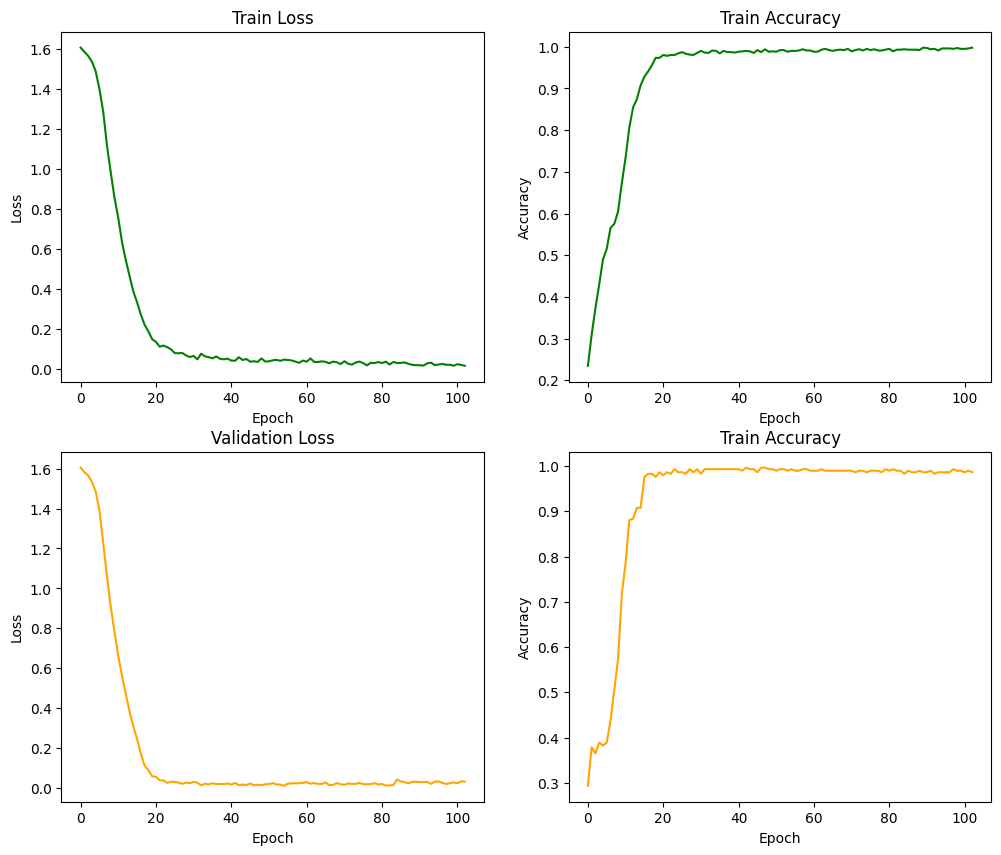

In [41]:
train_loss_list = train_val_loss_acc[0]
train_acc_list = train_val_loss_acc[1]
val_loss_list = train_val_loss_acc[2]
val_acc_list = train_val_loss_acc[3]

visualization(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

In [42]:
network = NeuralNetwork()
network.load_state_dict(torch.load(best_model_path, weights_only=False))

network.eval()
acc_test = Accuracy(num_classes=len(LIST_LABEL), task='MULTICLASS')
# with torch.no_grad:
for i, test_data in enumerate(test_loader):
  test_input, test_label = test_data
  #q7 A
  preds = network(test_input)
  acc_test.update(preds, test_label)

print(network.__class__.__name__)
print(f"Accuracy of model:{acc_test.compute().item()}")

NeuralNetwork
Accuracy of model:0.9724409580230713
